Mean squared error:  8066370.291483731


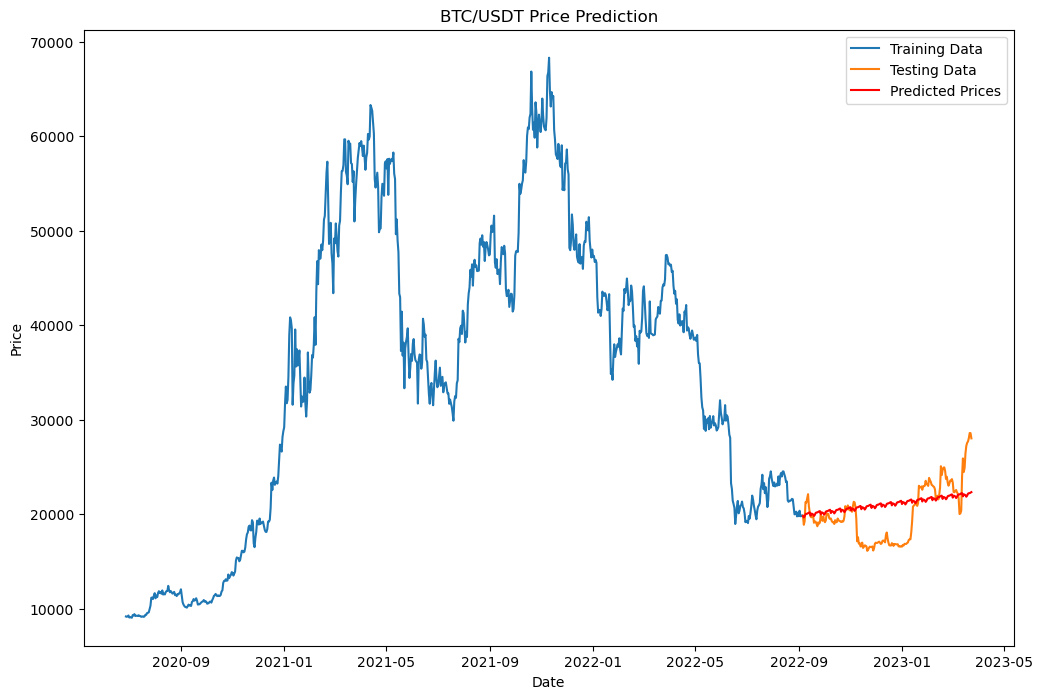

In [10]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Set the API endpoint and parameters
url = 'https://api.huobi.pro/market/history/kline'
payload = {'symbol': 'btcusdt', 'period': '1day', 'size': 1000}

# Send the request and retrieve the data
response = requests.get(url, params=payload)
data = response.json()

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data['data'])

# Convert the timestamp to a datetime object
df['timestamp'] = pd.to_datetime(df['id'], unit='s')

# Sort the data by the timestamp
df = df.sort_values(by='timestamp')

# Set the timestamp as the index and provide a frequency
df = df.set_index('timestamp')
df.index.freq = 'D'

# Rename columns for readability
df = df.rename(columns={'close': 'price'})

# Select only the Price column as the endog variable
endog = df['price']

# Split the data into training and testing sets
train_size = int(len(endog) * 0.8)
train_data, test_data = endog[0:train_size], endog[train_size:]

# Fit the SARIMAX model
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Make predictions for the testing set
predictions = model_fit.predict(start=len(train_data), end=len(df)-1, dynamic=False)

# Create an index for the predicted prices
pred_index = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Create a DataFrame for the predicted prices
pred_df = pd.DataFrame({'price': predictions}, index=pred_index)

# Evaluate the model using the mean squared error
mse = mean_squared_error(test_data, predictions)
print("Mean squared error: ", mse)

# Visualize the predictions
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Testing Data')
plt.plot(pred_index, predictions, label='Predicted Prices', color='red')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC/USDT Price Prediction')
plt.show()
